# LOOCV model comparisons

Last updated: 02-01-2024.

Code for performing LOOCV for the best performing LASSO-selected model, and comparing this model to other models (Fig. 4B-C, Extended Data Fig. 4-2, Fig. 5) 

This notebook contains part of the analysis pipeline and figures for the following manuscript: Maboudian et al., JNeurosci 2024. Defining overlooked structures reveals new associations between cortex and cognition in aging and Alzheimer’s disease (accepted).

For simplicity, this notebook references cleaned and formatted data from .csv files included in this repository. If you have any questions about the data please contact the corresponding author (Samira Maboudian).

# load packages & data


In [1]:
## packages ##
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

%matplotlib inline
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches

import pandas as pd
from scipy import stats

# import from sklearn CV and lasso
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.linear_model import Lasso
loo = LeaveOneOut()

## load sklearn functions for loocv ##
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
#from sklearn.utils import resample


In [2]:
## load data: wide df of thickness values for sulci, with cog (uwnpsych) scores -- hemis separate
df_npsych_morph_wide_thickness = pd.read_csv(
    'data/df_wide_npsych_demog_cortical-thickness-mean_CN72_AD72_forLASSO_final.csv')

# split by hemi
df_npsych_morph_wide_thickness_RightHem = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='rh']

df_npsych_morph_wide_thickness_LeftHem = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='lh']

print(len(df_npsych_morph_wide_thickness))
print(len(df_npsych_morph_wide_thickness_RightHem))
print(len(df_npsych_morph_wide_thickness_LeftHem))

df_npsych_morph_wide_thickness.head()


288
144
144


,Unnamed: 0,Subject,Group,Age,PTEDUCAT,Sex_binary,hemi,closest UWNPSYCH ADNI_MEM score,closest UWNPSYCH ADNI_EF score,icgs-p,...,mcgs,pos,prculs-d,prculs-v,prcus-a,prcus-i,prcus-p,spls,sspls-d,sspls-v
0,0,033_S_1016,CN,89.0,13.0,1,lh,0.676,0.428,NaN,...,2.001,2.163,1.809,2.452,2.249,2.049,2.719,2.344,2.623,2.976
1,1,033_S_1016,CN,89.0,13.0,1,rh,0.676,0.428,NaN,...,2.043,2.140,2.314,NaN,1.888,2.440,2.233,2.449,2.809,2.821
2,2,033_S_5017,AD,84.0,18.0,0,lh,-1.200,-0.881,2.775,...,2.005,2.121,1.849,NaN,2.001,1.995,2.443,2.424,NaN,NaN
3,3,033_S_5017,AD,84.0,18.0,0,rh,-1.200,-0.881,3.888,...,2.095,2.285,1.949,NaN,2.097,2.024,1.961,2.512,NaN,NaN
4,4,022_S_6069,CN,75.0,18.0,1,lh,1.355,0.422,3.770,...,2.265,2.385,2.134,2.619,2.005,2.289,2.102,2.372,3.000,NaN


In [3]:
## load data: wide df of depth values for sulci, with cog (uwnpsych) scores -- hemis separate
df_npsych_morph_wide_depth = pd.read_csv(
    'data/df_wide_npsych_demog_sulcal-depth_CN72_AD72_forLASSOFit_final.csv') #!!
df_npsych_morph_wide_depth.head()


,Subject,Group,hemi,closest UWNPSYCH ADNI_MEM score,closest UWNPSYCH ADNI_EF score,icgs-p,ifrms,mcgs,pos,prculs-d,...,prcus-a,prcus-i,prcus-p,spls,sspls-d,sspls-v,RID,Age,PTEDUCAT,Sex_binary
0,033_S_1016,CN,lh,0.676,0.428,NaN,2.645295,13.731280,18.870211,15.608343,...,9.432357,11.357565,2.922614,14.423120,3.476796,2.924995,1016,89.0,13.0,1
1,033_S_1016,CN,rh,0.676,0.428,NaN,1.160412,13.246197,19.444533,11.208692,...,8.681087,6.447894,7.412077,11.102627,1.641909,2.592221,1016,89.0,13.0,1
2,033_S_5017,AD,lh,-1.200,-0.881,5.038992,4.673288,17.533572,25.068557,19.010122,...,14.045920,13.052114,9.297483,13.591133,NaN,NaN,5017,84.0,18.0,0
3,033_S_5017,AD,rh,-1.200,-0.881,1.064722,2.079333,14.835316,25.965615,9.665424,...,6.817719,12.356560,6.206281,10.465629,NaN,NaN,5017,84.0,18.0,0
4,022_S_6069,CN,lh,1.355,0.422,1.993711,2.513207,15.980645,18.559036,20.760030,...,8.579968,14.998886,13.328153,14.381569,2.181236,NaN,6069,75.0,18.0,1


In [4]:
## load data: wide df of thickness values for sulci, with cog (uwnpsych) scores -- hemis combined
df_npsych_morph_wide_thickness_bothHem = pd.read_csv(
    'data/df_wide_npsych_demog_cortical-thickness-mean_both-hemis_CN72_AD72_forLASSO_final.csv')
df_npsych_morph_wide_thickness_bothHem.head()


,Unnamed: 0,Subject,Group,Group_bin,closest UWNPSYCH ADNI_MEM score,PTEDUCAT,Sex_binary,Age,icgs-p_lh,ifrms_lh,...,mcgs_rh,pos_rh,prculs-d_rh,prculs-v_rh,prcus-a_rh,prcus-i_rh,prcus-p_rh,spls_rh,sspls-d_rh,sspls-v_rh
0,0,033_S_1016,CN,1,0.676,13.0,1,89.0,NaN,3.128,...,2.043,2.140,2.314,NaN,1.888,2.440,2.233,2.449,2.809,2.821
1,1,033_S_5017,AD,0,-1.200,18.0,0,84.0,2.775,2.629,...,2.095,2.285,1.949,NaN,2.097,2.024,1.961,2.512,NaN,NaN
2,2,022_S_6069,CN,1,1.355,18.0,1,75.0,3.770,3.117,...,2.147,2.321,2.255,2.839,2.113,2.171,2.367,2.329,2.854,2.462
3,3,007_S_4488,CN,1,1.061,18.0,0,79.0,NaN,3.129,...,2.092,2.268,2.157,2.476,2.162,2.196,2.943,2.286,3.190,3.021
4,4,033_S_5013,AD,0,-0.897,18.0,1,68.0,NaN,2.932,...,2.064,2.268,2.294,2.090,2.199,1.954,2.401,2.275,2.764,2.179


# functions

In [5]:
## LOOCV ##
def lm_loocv (Xr, yr, mod):
    """
    linear regression with a leave-one-subject out cross validation proceedure. 
    input: input: Xr = matrix or array of predictors from dataframe  in format X= df[['X1', 'X2', 'Xn']]
    yr = Array of DV of interest from dataframe in format y= df['yr']
    mod = model name as strip. will be used to save a .csv with model predictions are saved as file for later use
    returns: r_squared-cv, mean squared error, dataframe of measured and predicted y-values.

    """    
    
    # create arrays to append y-vals
    ytests = []
    ypreds = []
    
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
 
     # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        # model to fit
        lm = linear_model.LinearRegression() 
        
        # fit model on training data
        model = lm.fit(X_train,y_train) 
        
        # generate predictions with testing data
        y_pred = lm.predict(X_test) 
        
        #there is only one y-test and y-pred per iteration over the loo.split, 
        #so we append each score to respective lists.
        
        ytests += list(y_test) #should be your original y input
        ypreds += list(y_pred)

    #get mean squared error and R2-cv values by comparing the test to the predicted.       
    rr = metrics.r2_score(ytests, ypreds)  #https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score
    ms_error = metrics.mean_squared_error(ytests, ypreds)
    
    # save predicted/measured scores as a dataframe (and write to csv)
    model_preds = pd.DataFrame({"Measured": ytests, "Predicted": ypreds})
    model_preds.to_csv(path_or_buf= mod + ".csv")
    
    # return regression fit metrics
    return rr , ms_error, model_preds 



def lm_loocv_withSubs(Xr, yr, subID, mod):
    """
    linear regression with a leave-one-subject out cross validation procedure, 
    which also keeps the subject label in case it's needed later (e.g. to split results by group). 
    input: input: Xr = matrix or array of predictors from dataframe  in format X= df[['X1', 'X2', 'Xn']]
    yr = Array of DV of interest from dataframe in format y= df['yr']
    mod = model name as strip. will be used to save a .csv with model predictions are saved as file for later use
    returns: r_squared-cv, mean squared error, dataframe of measured and predicted y-values.

    """    
    
    # create arrays to append y-vals
    ytests = []
    ypreds = []
    ids = []
    
    # set input arrays as np objects
    X_array = np.array(Xr)
    y_array = np.array(yr)
    subID_array = np.array(subID)
 
     # split into train and test
    for train_idx, test_idx in loo.split(Xr):
        X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
        y_train, y_test = y_array[train_idx], y_array[test_idx]
        subID = subID_array[test_idx]

        # model to fit
        lm = linear_model.LinearRegression() 
        
        # fit model on training data
        model = lm.fit(X_train,y_train) 
        
        # generate predictions with testing data
        y_pred = lm.predict(X_test) 
        
        #there is only one y-test and y-pred per iteration over the loo.split, 
        #so we append each score to respective lists.
        
        ytests += list(y_test) #should be your original y input
        ypreds += list(y_pred)
        ids += list(subID)
    #get mean squared error and R2-cv values by comparing the test to the predicted.       
    rr = metrics.r2_score(ytests, ypreds)  #https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score
    ms_error = metrics.mean_squared_error(ytests, ypreds)
    
    # save predicted/measured scores as a dataframe (and write to csv)
    model_preds = pd.DataFrame({"Measured": ytests, "Predicted": ypreds, "Subject":ids})
    model_preds.to_csv(path_or_buf= mod + ".csv")
    
    # return regression fit metrics
    return rr , ms_error, model_preds  

In [6]:
## AIC ##

def calculate_aic(n, mse, num_params):
    '''
    input:
    - n = num observations
    - mse =. mean squared error from regression
    - num_params = number of predictors in the model (including the intercept if applicable!)
    '''
    aic = n *np.log(mse) + 2 * num_params
    return aic

# ADNI_MEM Models (thickness)

## Right hemisphere
### model 1a: right hem, Mem composite; best LASSO model

In [7]:
## set up model for predictors from LASSO 

# x-vals 
Xr = ['prculs-d', 'prcus-p', 'ifrms', 'sspls-v' ] #final rh LASSO model
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [8]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_rh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='rh']
df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_rh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_MEM_rh.dropna()

In [9]:
## predict reasoning score ##
mod_1a = lm_loocv_withSubs(df_npsych_morph_wide_thickness_MEM_rh[Xr], 
                  df_npsych_morph_wide_thickness_MEM_rh[yr], 
                  df_npsych_morph_wide_thickness_MEM_rh['Subject'], "model_1a")

In [10]:
# print R2 and MSE
print(mod_1a[0], mod_1a[1])

0.2692405148291557 0.8426259279769222


In [11]:
## AIC 
num_params = len(Xr)+1
AIC_1a = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_rh), mod_1a[1], num_params)
print(AIC_1a)

-1.9862510961374795


In [12]:
# add group to measured/predicted values to separate on plot
measured_df = df_npsych_morph_wide_thickness_rh[['Subject','closest UWNPSYCH ADNI_MEM score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_MEM score': 'Measured'})  #, 'b': 'Y'})
measured_df = measured_df.dropna()

print(len(mod_1a[2]))
mod1a_subs = mod_1a[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod1a_subs))
mod1a_subs.head()

70
70


,Measured,Predicted,Subject,Group
0,0.676,0.523476,033_S_1016,CN
1,1.355,0.480956,022_S_6069,CN
2,1.061,0.981494,007_S_4488,CN
3,-0.897,0.051803,033_S_5013,AD
4,0.735,0.511379,007_S_4620,CN


r_p:  0.5252126586797959 
p:  3.0404563051229745e-06

r_s:  0.5499654445617197 
p:  8.161090421659408e-07


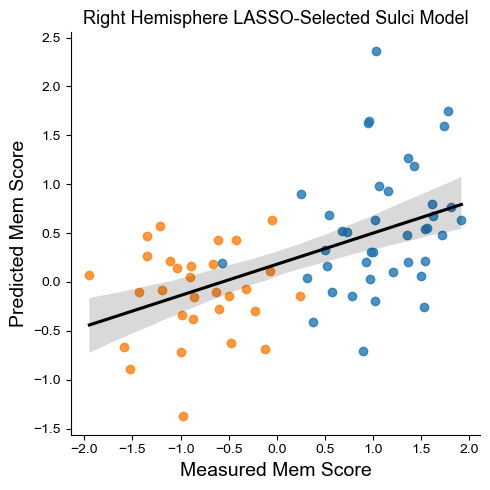

In [13]:
# use lmplot to plot the groups
graph = sns.lmplot(x='Measured', y='Predicted', hue='Group', data=mod1a_subs, fit_reg=False, legend = False);

# use regplot to plot the regression line
sns.regplot(x='Measured', y='Predicted', data=mod_1a[2],  ax=graph.axes[0, 0], color='black', scatter=False);

r, p = stats.pearsonr(mod_1a[2]['Measured'], mod_1a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_1a[2]['Measured'], mod_1a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.title('Right Hemisphere LASSO-Selected Sulci Model', fontsize=13)
plt.tight_layout()


r_p:  0.5252126586797959 
p:  3.0404563051229745e-06

r_s:  0.5499654445617197 
p:  8.161090421659408e-07


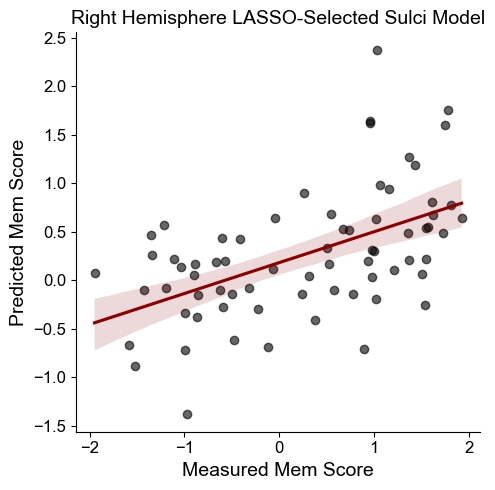

In [14]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod1a_subs, fit_reg=False);

sns.regplot(x='Measured', y='Predicted', data=mod_1a[2],  ax=graph.axes[0, 0], color='darkred', scatter=False);

r, p = stats.pearsonr(mod_1a[2]['Measured'], mod_1a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_1a[2]['Measured'], mod_1a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.xticks([-2,-1,0,1,2])
plt.title('Right Hemisphere LASSO-Selected Sulci Model', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()


### model 1b: right hem, Mem composite; all predictors model

In [15]:
## set up model 

# x-vals 
Xr = ['pos','prculs-d','prcus-p','prcus-i','prcus-a','spls','mcgs','ifrms', 'sspls-v']
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [16]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_rh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='rh']
df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_rh[Xr+[yr]]

df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_MEM_rh.dropna()

In [17]:
## predict reasoning score ##
mod_1b = lm_loocv(df_npsych_morph_wide_thickness_MEM_rh[Xr], df_npsych_morph_wide_thickness_MEM_rh[yr], "model_1b")

In [18]:
# print R2 and MSE
print(mod_1b[0], mod_1b[1])

0.15230639263384815 0.9774606105591839


In [19]:
## AIC 
num_params = len(Xr)+1
AIC_1b = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_rh), mod_1b[1], num_params)
AIC_1b

18.404190117363612

### model 1c: right hem, Mem composite; LASSO sulci + covariates model


In [20]:
## set up model  

# x-vals 
Xr = ['prculs-d', 'prcus-p', 'ifrms', 'sspls-v' , 'Age', 'PTEDUCAT', 'Sex_binary' ] #final 72x2 model
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [21]:
# select relevant hemi + columns 

df_npsych_morph_wide_thickness_rh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='rh']
df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_rh[Xr+[yr]]

df_npsych_morph_wide_thickness_MEM_rh = df_npsych_morph_wide_thickness_MEM_rh.dropna()

In [22]:
## predict reasoning score ##
mod_1c = lm_loocv(df_npsych_morph_wide_thickness_MEM_rh[Xr], 
                  df_npsych_morph_wide_thickness_MEM_rh[yr], "model_1c")

In [23]:
# print R2 and MSE
print(mod_1c[0], mod_1c[1]) 

0.2579029723147275 0.855699049128356


In [24]:
## AIC 
num_params = len(Xr)+1
AIC_1c = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_rh), mod_1c[1], num_params)
AIC_1c

5.091442005431386

## Left hemisphere
### model 2a: left hem, Mem composite; best LASSO model


In [25]:
## set up model for predictors from LASSO 

# x-vals 
Xr = ['pos', 'prcus-p', 'spls', 'sspls-v']
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [26]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_lh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='lh']
df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_lh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_MEM_lh.dropna()

In [27]:
## predict reasoning score ##
mod_2a = lm_loocv_withSubs(df_npsych_morph_wide_thickness_MEM_lh[Xr], 
                  df_npsych_morph_wide_thickness_MEM_lh[yr],
                  df_npsych_morph_wide_thickness_MEM_lh['Subject'],
                  "model_2a")

In [28]:
# print R2 and MSE
print(mod_2a[0], mod_2a[1])

0.168061390431676 1.001559475992645


In [29]:
## AIC 
num_params = len(Xr)+1
AIC_2a = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_lh), mod_2a[1], num_params)
AIC_2a

10.166733956176712

In [30]:
# # add group to measured/predicted values to separate on plot
measured_df = df_npsych_morph_wide_thickness_lh[['Subject','closest UWNPSYCH ADNI_MEM score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_MEM score': 'Measured'})  #, 'b': 'Y'})
measured_df = measured_df.dropna()

print(len(mod_2a[2]))
mod2a_subs = mod_2a[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod2a_subs))
mod2a_subs.head()

107
107


,Measured,Predicted,Subject,Group
0,0.676,0.385160,033_S_1016,CN
1,1.061,0.742310,007_S_4488,CN
2,-0.874,-0.338896,019_S_4252,AD
3,0.735,0.397852,007_S_4620,CN
4,-0.220,0.193020,068_S_4859,AD


r_p:  0.418116736309745 
p:  7.41902617154887e-06

r_s:  0.4120633536703753 
p:  1.0340577127755768e-05


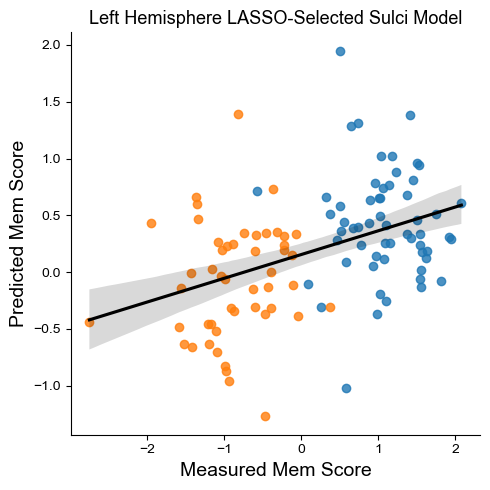

In [31]:
colors = { "AD": "C1", "CN": "C0"}

# use lmplot to plot the groups
graph = sns.lmplot(x='Measured', y='Predicted', hue='Group', 
                   data=mod2a_subs, fit_reg=False, 
                   palette=colors,
                   legend = False);
# use regplot to plot the regression line
sns.regplot(x='Measured', y='Predicted', data=mod_2a[2],  ax=graph.axes[0, 0], color='black', scatter=False);


r, p = stats.pearsonr(mod_2a[2]['Measured'], mod_2a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_2a[2]['Measured'], mod_2a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.title('Left Hemisphere LASSO-Selected Sulci Model', fontsize=13)
plt.tight_layout()


r_p:  0.418116736309745 
p:  7.41902617154887e-06

r_s:  0.4120633536703753 
p:  1.0340577127755768e-05


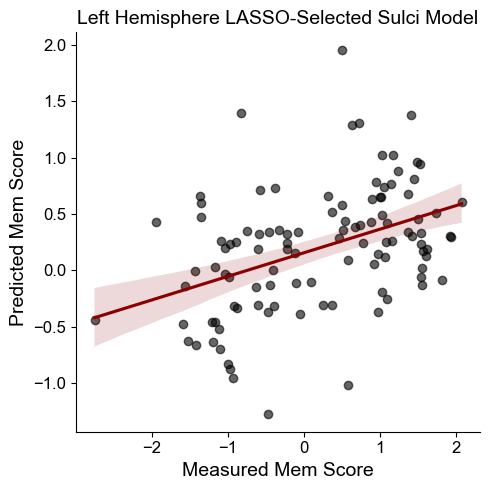

In [32]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod2a_subs, fit_reg=False);
sns.regplot(x='Measured', y='Predicted', data=mod_2a[2],  ax=graph.axes[0, 0], color='darkred', scatter=False);

r, p = stats.pearsonr(mod_2a[2]['Measured'], mod_2a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_2a[2]['Measured'], mod_2a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.title('Left Hemisphere LASSO-Selected Sulci Model', fontsize=14)

plt.xticks([-2,-1,0,1,2])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()


### model 2b: left hem, Mem composite; all sulci model


In [33]:
## set up model 

# x-vals 
Xr = ['pos','prculs-d','prcus-p','prcus-i','prcus-a','spls','mcgs','ifrms', 'sspls-v']
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [34]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_lh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='lh']
df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_lh[Xr+[yr]]

df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_MEM_lh.dropna()

In [35]:
## predict reasoning score ##
mod_2b = lm_loocv(df_npsych_morph_wide_thickness_MEM_lh[Xr], df_npsych_morph_wide_thickness_MEM_lh[yr], "model_2b")

In [36]:
# print R2 and MSE
print(mod_2b[0], mod_2b[1])

0.0803820497826856 1.1045124888688915


In [37]:
#AIC
num_params = len(Xr)+1
AIC_2b = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_lh), mod_2b[1], num_params)
AIC_2b

30.53682941387673

### model 2c: left hem, Mem composite; LASSO sulci + covariates model

In [38]:
## set up model for predictors from LASSO 

# x-vals 
Xr = ['pos', 'prcus-p', 'spls', 'sspls-v',
     'Age', 'PTEDUCAT', 'Sex_binary'] 
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [39]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_lh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='lh']
df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_lh[Xr+[yr]]

df_npsych_morph_wide_thickness_MEM_lh = df_npsych_morph_wide_thickness_MEM_lh.dropna()

In [40]:
## predict reasoning score ##
mod_2c = lm_loocv(df_npsych_morph_wide_thickness_MEM_lh[Xr], 
                  df_npsych_morph_wide_thickness_MEM_lh[yr], "model_2c")

In [41]:
# print R2 and MSE
print(mod_2c[0], mod_2c[1])

0.15897338218412005 1.0125004044139885


In [42]:
#AIC
num_params = len(Xr)+1
AIC_2c = calculate_aic(len(df_npsych_morph_wide_thickness_MEM_lh), mod_2c[1], num_params)
AIC_2c

17.32925237790796

# model comparison

### AIC

In order to assess the fit we will compare the AIC value of each model. The model with the lowest AIC is better. To report a difference the difference in AIC must be > 2. A difference > 10 is considered substantial.



In [43]:
print(AIC_1a)
print(AIC_1b)
print(AIC_1c)
print('---')
print(AIC_2a)
print(AIC_2b)
print(AIC_2c)

-1.9862510961374795
18.404190117363612
5.091442005431386
---
10.166733956176712
30.53682941387673
17.32925237790796


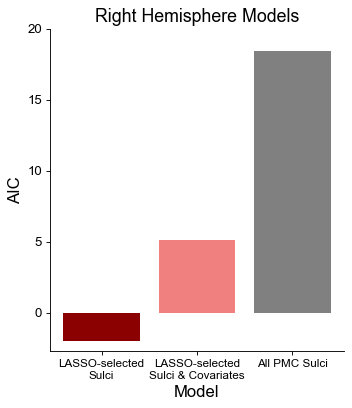

In [44]:
# model 1a: right hem, Mem composite; best LASSO model
# model 1b: right hem, Mem composite; all predictors (all sulci) model
# model 1c: right hem, Mem composite; LASSO sulci + covariates model

#  R2 and MSE
mod_1a[0], mod_1a[1]

fig,ax = plt.subplots(figsize=(4.5, 5.2), dpi=80)

height = [AIC_1a, AIC_1c,AIC_1b]
          
bars = ('LASSO-selected\nSulci',
        'LASSO-selected\nSulci & Covariates','All PMC Sulci')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=['darkred', 'lightcoral','gray'])

# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=10)
plt.ylim([-2.7,20])
plt.ylabel('AIC', fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.title('Right Hemisphere Models', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=10.5)
plt.yticks(fontsize=12)

plt.tight_layout()


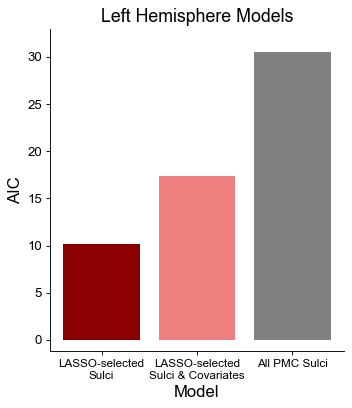

In [45]:
# model 2a: left hem, Mem composite; best LASSO model
# model 2b: left hem, Mem composite; all predictors (all sulci) model
# model 2c: left hem, Mem composite; LASSO sulci + covariates model

#  R2 and MSE
mod_2a[0], mod_2a[1]

fig,ax = plt.subplots(figsize=(4.5, 5.2), dpi=80)

height = [AIC_2a, AIC_2c,AIC_2b]
          
bars = ('LASSO-selected\nSulci',
        'LASSO-selected\nSulci & Covariates','All PMC Sulci')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=['darkred','lightcoral','gray'])

# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=10)
plt.ylim([-1.2,33])
plt.ylabel('AIC', fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.title('Left Hemisphere Models', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=10.5)
plt.yticks(fontsize=12)

plt.tight_layout()


# ADNI_EF Models (thickness)

### model 3a: right hem, EF composite; LASSO sulci

In [46]:
## set up model 

# x-vals 
Xr = ['prculs-d', 'prcus-p', 'ifrms', 'sspls-v' ] #final 72x2 model
# predicting score
yr = 'closest UWNPSYCH ADNI_EF score'

In [47]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_rh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='rh']
df_npsych_morph_wide_thickness_EF_rh = df_npsych_morph_wide_thickness_rh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_thickness_EF_rh = df_npsych_morph_wide_thickness_EF_rh.dropna()

In [48]:
## predict reasoning score ##
mod_3a = lm_loocv_withSubs(df_npsych_morph_wide_thickness_EF_rh[Xr], 
                  df_npsych_morph_wide_thickness_EF_rh[yr], 
                  df_npsych_morph_wide_thickness_EF_rh['Subject'],"model_3a")

In [49]:
# print R2 and MSE
print(mod_3a[0], mod_3a[1])

0.1895573070719644 1.1942690535797773


In [50]:
## AIC 
num_params = len(Xr)+1
AIC_3a = calculate_aic(len(df_npsych_morph_wide_thickness_EF_rh), mod_3a[1], num_params)
AIC_3a

22.427402931449016

In [51]:
measured_df = df_npsych_morph_wide_thickness_rh[['Subject','closest UWNPSYCH ADNI_EF score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_EF score': 'Measured'}) 
measured_df = measured_df.dropna()

print(len(mod_3a[2]))
mod3a_subs = mod_3a[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod3a_subs))
mod3a_subs.head()

70
70


,Measured,Predicted,Subject,Group
0,0.428,0.753545,033_S_1016,CN
1,0.422,0.659937,022_S_6069,CN
2,1.992,0.984879,007_S_4488,CN
3,-0.025,0.190563,033_S_5013,AD
4,1.060,0.648602,007_S_4620,CN


r_p:  0.44808703262428556 
p:  0.00010031812101933713

r_s:  0.4843363164940515 
p:  2.1535605089612858e-05


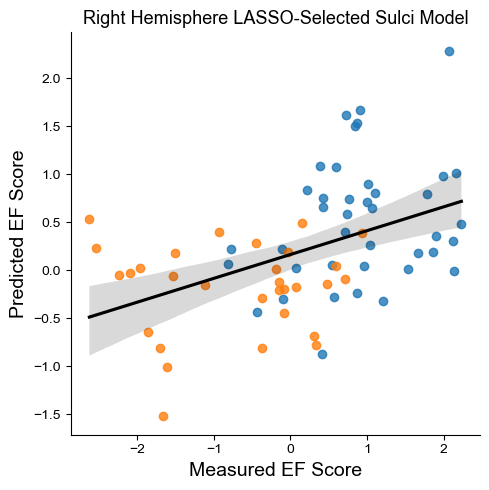

In [52]:
graph = sns.lmplot(x='Measured', y='Predicted', hue='Group', data=mod3a_subs, fit_reg=False,
                  legend=False);
# Use regplot to plot the regression line
sns.regplot(x='Measured', y='Predicted', data=mod_3a[2],  ax=graph.axes[0, 0], color='black', scatter=False);

r, p = stats.pearsonr(mod_3a[2]['Measured'], mod_3a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_3a[2]['Measured'], mod_3a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured EF Score', fontsize=14)
plt.ylabel('Predicted EF Score', fontsize=14)
plt.title('Right Hemisphere LASSO-Selected Sulci Model', fontsize=13)
plt.tight_layout()


r_p:  0.44808703262428556 
p:  0.00010031812101933713

r_s:  0.4843363164940515 
p:  2.1535605089612858e-05


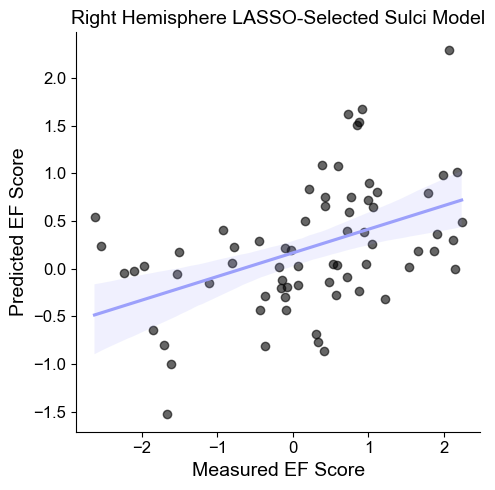

In [53]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod3a_subs, fit_reg=False);
#Use regplot to plot the regression line for the whole points
sns.regplot(x='Measured', y='Predicted', data=mod_3a[2],  ax=graph.axes[0, 0], color='#9CA0FB', scatter=False);

r, p = stats.pearsonr(mod_3a[2]['Measured'], mod_3a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)


r, p = stats.spearmanr(mod_3a[2]['Measured'], mod_3a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured EF Score', fontsize=14)
plt.ylabel('Predicted EF Score', fontsize=14)
plt.title('Right Hemisphere LASSO-Selected Sulci Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()


### model 3b: left hem, EF composite; LASSO sulci

In [54]:
## set up model 
# x-vals 
Xr = ['pos', 'prcus-p', 'spls', 'sspls-v']
# predicting score
yr = 'closest UWNPSYCH ADNI_EF score'

In [55]:
# select relevant hemi + columns 
df_npsych_morph_wide_thickness_lh = df_npsych_morph_wide_thickness[
    df_npsych_morph_wide_thickness['hemi']=='lh']
df_npsych_morph_wide_thickness_EF_lh = df_npsych_morph_wide_thickness_lh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_thickness_EF_lh = df_npsych_morph_wide_thickness_EF_lh.dropna()

In [56]:
## predict reasoning score ##
mod_3b = lm_loocv_withSubs(df_npsych_morph_wide_thickness_EF_lh[Xr], 
                  df_npsych_morph_wide_thickness_EF_lh[yr], 
                  df_npsych_morph_wide_thickness_EF_lh['Subject'], "model_3b")

In [57]:
# print R2 and MSE
print(mod_3b[0], mod_3b[1])

0.1428313594435323 1.5476567075961276


In [58]:
## AIC 
num_params = len(Xr)+1
AIC_3b = calculate_aic(len(df_npsych_morph_wide_thickness_EF_lh), mod_3b[1], num_params)
AIC_3b

56.294650458254885

In [59]:
measured_df = df_npsych_morph_wide_thickness_lh[['Subject','closest UWNPSYCH ADNI_EF score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_EF score': 'Measured'}) 
measured_df = measured_df.dropna()

print(len(mod_3b[2]))
mod3b_subs = mod_3b[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod3b_subs))
mod3b_subs.head()

106
106


,Measured,Predicted,Subject,Group
0,0.428,0.255295,033_S_1016,CN
1,1.992,0.864241,007_S_4488,CN
2,-1.420,-0.281910,019_S_4252,AD
3,1.060,0.476580,007_S_4620,CN
4,-0.153,0.378603,068_S_4859,AD


r_p:  0.38751202536873125 
p:  4.062054895526662e-05

r_s:  0.395500862827841 
p:  2.7159672466840722e-05


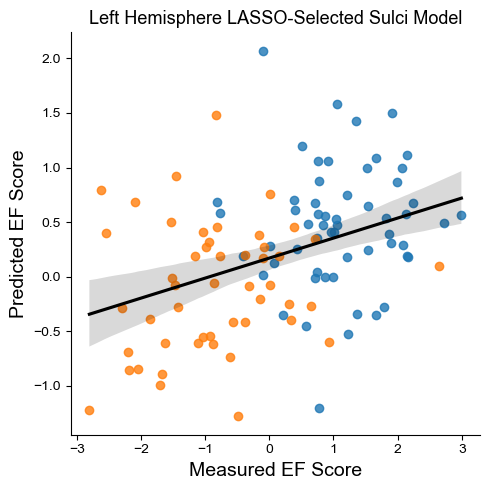

In [60]:
colors = { "AD": "C1",
          "CN": "C0"}

graph = sns.lmplot(x='Measured', y='Predicted', hue='Group',
                   data=mod3b_subs, fit_reg=False,
                   palette=colors,
                  legend=False);
# use regplot to plot the regression line
sns.regplot(x='Measured', y='Predicted', data=mod_3b[2],  ax=graph.axes[0, 0], color='black', scatter=False);

r, p = stats.pearsonr(mod_3b[2]['Measured'], mod_3b[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_3b[2]['Measured'], mod_3b[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

#ax.get_legend().remove()
plt.xlabel('Measured EF Score', fontsize=14)
plt.ylabel('Predicted EF Score', fontsize=14)
plt.title('Left Hemisphere LASSO-Selected Sulci Model', fontsize=13)
plt.tight_layout()


r_p:  0.38751202536873125 
p:  4.062054895526662e-05

r_s:  0.395500862827841 
p:  2.7159672466840722e-05


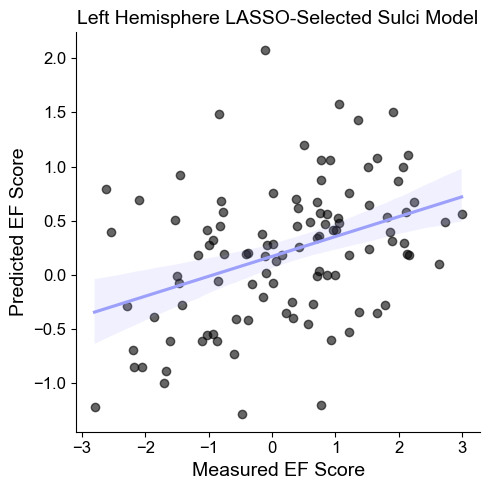

In [61]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod3b_subs, fit_reg=False);
#Use regplot to plot the regression line for the whole points
sns.regplot(x='Measured', y='Predicted', data=mod_3b[2],  ax=graph.axes[0, 0], color='#9CA0FB', scatter=False);

r, p = stats.pearsonr(mod_3b[2]['Measured'], mod_3b[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_3b[2]['Measured'], mod_3b[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured EF Score', fontsize=14)
plt.ylabel('Predicted EF Score', fontsize=14)
plt.title('Left Hemisphere LASSO-Selected Sulci Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()


## model comparisons: Mem & EF

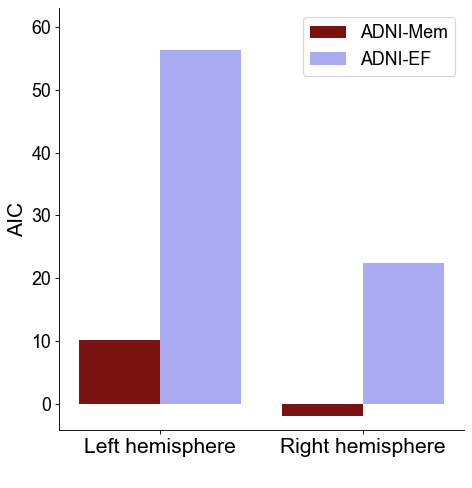

In [62]:
fig,ax = plt.subplots(figsize=(6, 6.2), dpi=80)


height = [#LH
          AIC_2a, # AIC_2a for orig CT Mem model 
          AIC_3b,
          
          #RH
          AIC_1a, # AIC_1a for orig CT Mem model 
          AIC_3a]
          
bars = ('LASSO-selected\nSulci, ADNI-Mem',
        'LASSO-selected\nSulci, ADNI-EF',
        'LASSO-selected\nSulci, ADNI-Mem',
        'LASSO-selected\nSulci, ADNI-EF')
y_pos = np.arange(len(bars))

df_AIC_EFmodels = pd.DataFrame([['Left hemisphere', 'LASSO-selected\nSulci, ADNI-Mem', 'ADNI-Mem', AIC_2a], 
                   ['Left hemisphere', 'LASSO-selected\nSulci, ADNI-EF',  'ADNI-EF',  AIC_3b], 
                   ['Right hemisphere', 'LASSO-selected\nSulci, ADNI-Mem', 'ADNI-Mem', AIC_1a], 
                   ['Right hemisphere', 'LASSO-selected\nSulci, ADNI-EF',  'ADNI-EF',  AIC_3a]], 
                  columns=['hemi', 'full model name', 'model', 'AIC']) 

colors={'ADNI-Mem':'darkred', 
        'ADNI-EF':'#9CA0FB'}

# Create bars
sns.barplot(data=df_AIC_EFmodels, x='hemi', y='AIC', hue='model', palette=colors)

# Create names on the x-axis
plt.yticks(fontsize=16)
plt.xticks(fontsize=19)
plt.ylim([-4.1,63])
plt.ylabel('AIC', fontsize=19)
plt.xlabel(' ', fontsize=19)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(fontsize=16)

# Show graphic
plt.tight_layout()


# Depth

### model 4a: right hem, Mem composite; thickness LASSO sulci


In [63]:
## set up model 
# x-vals 
Xr = ['prculs-d', 'prcus-p', 'ifrms', 'sspls-v' ] #final model
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [64]:
# select relevant hemi + columns 
df_npsych_morph_wide_depth_rh = df_npsych_morph_wide_depth[
    df_npsych_morph_wide_depth['hemi']=='rh']
df_npsych_morph_wide_depth_MEM_rh = df_npsych_morph_wide_depth_rh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_depth_MEM_rh = df_npsych_morph_wide_depth_MEM_rh.dropna()

In [65]:
## predict reasoning score ##
mod_4a = lm_loocv_withSubs(df_npsych_morph_wide_depth_MEM_rh[Xr], 
                  df_npsych_morph_wide_depth_MEM_rh[yr], 
                  df_npsych_morph_wide_depth_MEM_rh['Subject'],"model_4a")

In [66]:
# print R2 and MSE
print(mod_4a[0], mod_4a[1]) 

-0.031634800305488264 1.1895599695670993


In [67]:
## AIC 
num_params = len(Xr)+1
AIC_4a = calculate_aic(len(df_npsych_morph_wide_depth_MEM_rh), mod_4a[1], num_params)
AIC_4a

22.150842568714047

In [68]:
measured_df = df_npsych_morph_wide_depth_rh[['Subject','closest UWNPSYCH ADNI_MEM score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_MEM score': 'Measured'})  #, 'b': 'Y'})
measured_df = measured_df.dropna()

print(len(mod_4a[2]))
mod4a_subs = mod_4a[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod4a_subs))
mod4a_subs.head()


70
70


,Measured,Predicted,Subject,Group
0,0.676,0.415030,033_S_1016,CN
1,1.355,0.155785,022_S_6069,CN
2,1.061,0.318402,007_S_4488,CN
3,-0.897,-1.136190,033_S_5013,AD
4,0.735,0.514281,007_S_4620,CN


r_p:  0.11345421977802052 
p:  0.34970650509871903

r_s:  0.09729767560231994 
p:  0.4229597349794906


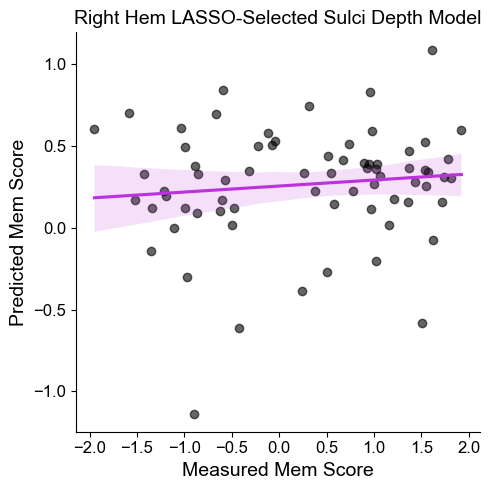

In [69]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod4a_subs, fit_reg=False);
#Use regplot to plot the regression line for the whole points
sns.regplot(x='Measured', y='Predicted', data=mod_4a[2],  ax=graph.axes[0, 0], color='#BC33DE', scatter=False);

r, p = stats.pearsonr(mod_4a[2]['Measured'], mod_4a[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_4a[2]['Measured'], mod_4a[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.title('Right Hem LASSO-Selected Sulci Depth Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()


### model 4b: left hem, Mem composite; thickness LASSO sulci

In [70]:
## set up model 
# x-vals 
Xr = ['pos', 'prcus-p', 'spls', 'sspls-v']
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [71]:
# select relevant hemi + columns 
df_npsych_morph_wide_depth_lh = df_npsych_morph_wide_depth[
    df_npsych_morph_wide_depth['hemi']=='lh']
df_npsych_morph_wide_depth_MEM_lh = df_npsych_morph_wide_depth_lh[Xr+[yr]+['Subject']]

df_npsych_morph_wide_depth_MEM_lh = df_npsych_morph_wide_depth_MEM_lh.dropna()

In [72]:
## predict reasoning score ##
mod_4b = lm_loocv_withSubs(df_npsych_morph_wide_depth_MEM_lh[Xr], 
                  df_npsych_morph_wide_depth_MEM_lh[yr],
                  df_npsych_morph_wide_depth_MEM_lh['Subject'],"model_4b")

In [73]:
# print R2 and MSE
print(mod_4b[0], mod_4b[1])

-0.005126014243910015 1.210057415961328


In [74]:
## AIC 
num_params = len(Xr)+1
AIC_4b = calculate_aic(len(df_npsych_morph_wide_depth_MEM_lh), mod_4b[1], num_params)
AIC_4b

30.40145563689269

In [75]:
measured_df = df_npsych_morph_wide_depth_lh[['Subject','closest UWNPSYCH ADNI_MEM score','Group']]
measured_df = measured_df.rename(columns={'closest UWNPSYCH ADNI_MEM score': 'Measured'})  #, 'b': 'Y'})
measured_df = measured_df.dropna()

print(len(mod_4b[2]))
mod4b_subs = mod_4b[2].merge(measured_df, on=['Subject','Measured'])
print(len(mod4b_subs))
mod4b_subs.head()


107
107


,Measured,Predicted,Subject,Group
0,0.676,0.436267,033_S_1016,CN
1,1.061,-0.275496,007_S_4488,CN
2,-0.874,0.191773,019_S_4252,AD
3,0.735,0.390018,007_S_4620,CN
4,-0.220,0.122374,068_S_4859,AD


r_p:  0.1429625528675835 
p:  0.14183177157759577

r_s:  0.1718885849272013 
p:  0.07666938543121742


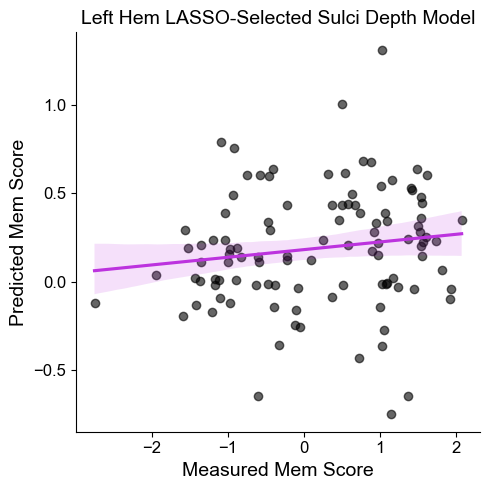

In [76]:
graph = sns.lmplot(x='Measured', y='Predicted', scatter_kws={'color':'black', 'alpha':0.6}, 
                   data=mod4b_subs, fit_reg=False);
#Use regplot to plot the regression line for the whole points
sns.regplot(x='Measured', y='Predicted', data=mod_4b[2],  ax=graph.axes[0, 0], color='#BC33DE', scatter=False);

r, p = stats.pearsonr(mod_4b[2]['Measured'], mod_4b[2]['Predicted'])
print('r_p: ',r, '\np: ',p)

r, p = stats.spearmanr(mod_4b[2]['Measured'], mod_4b[2]['Predicted'])
print('\nr_s: ',r, '\np: ',p)

plt.xlabel('Measured Mem Score', fontsize=14)
plt.ylabel('Predicted Mem Score', fontsize=14)
plt.title('Left Hem LASSO-Selected Sulci Depth Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()


## model comparisons: depth & thickness

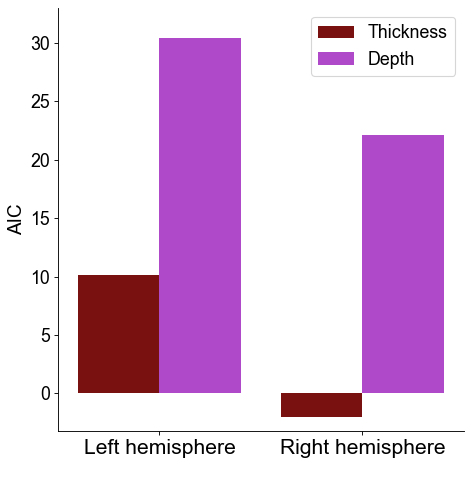

In [77]:
fig,ax = plt.subplots(figsize=(6, 6.2), dpi=80)


height = [#LH
          AIC_2a, # AIC_2a for orig CT Mem model 
          AIC_4b,
          
          #RH
          AIC_1a, # AIC_1a for orig CT Mem model 
          AIC_4a]
          
bars = ('LASSO-selected\nSulci, Thickness',
        'LASSO-selected\nSulci, Depth',
        'LASSO-selected\nSulci, Thickness',
        'LASSO-selected\nSulci, Depth')
y_pos = np.arange(len(bars))


df_AIC_EFmodels = pd.DataFrame([['Left hemisphere', 'LASSO-selected\nSulci, Thickness', 'Thickness', AIC_2a], 
                   ['Left hemisphere', 'LASSO-selected\nSulci, Depth',  'Depth',  AIC_4b], 
                   ['Right hemisphere', 'LASSO-selected\nSulci, Thickness', 'Thickness', AIC_1a], 
                   ['Right hemisphere', 'LASSO-selected\nSulci, Depth',  'Depth',  AIC_4a]], 
                  columns=['hemi', 'full model name', 'model', 'AIC']) 

colors={'Thickness':'darkred', 
        'Depth':'#BC33DE'}

# Create bars
sns.barplot(data=df_AIC_EFmodels, x='hemi', y='AIC', hue='model', palette=colors)

# Create names on the x-axis
plt.yticks(fontsize=16)
plt.xticks(fontsize=19)
plt.ylim([-3.2,33])
plt.ylabel('AIC', fontsize=17)
plt.xlabel(' ', fontsize=17)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(fontsize=16)

# Show graphic
#plt.show()
plt.tight_layout()


# Both hemispheres combined LASSO model

In [78]:
## set model for predictors from LASSO 

# x-vals 
Xr = [ 'prcus-p_rh', 'spls_rh', 'ifrms_rh', 'sspls-v_rh','sspls-v_lh','Group_bin' ] #final 72x2 model
# predicting score
yr = 'closest UWNPSYCH ADNI_MEM score'

In [79]:
# select relevant hemi + columns 

df_npsych_morph_wide_thickness_bothHem_rh = df_npsych_morph_wide_thickness_bothHem.copy()
df_npsych_morph_wide_thickness_bothHem_MEM_rh = df_npsych_morph_wide_thickness_bothHem_rh[Xr+[yr]]

df_npsych_morph_wide_thickness_bothHem_MEM_rh = df_npsych_morph_wide_thickness_bothHem_MEM_rh.dropna()

In [80]:
## predict reasoning score ##
mod_5 = lm_loocv(df_npsych_morph_wide_thickness_bothHem_MEM_rh[Xr], 
                 df_npsych_morph_wide_thickness_bothHem_MEM_rh[yr], "model_5")

In [81]:
# print R2 and MSE
print(mod_5[0], mod_5[1])

0.7593024875757273 0.27838549052992295


In [82]:
## AIC 
num_params = len(Xr)+1
AIC_5 = calculate_aic(len(df_npsych_morph_wide_thickness_bothHem_MEM_rh), mod_5[1], num_params)
print(AIC_5)

-55.052417338389944
